# Authorship Detection

Data Source: http://www.gutenberg.org/

14 American and British authors (7 male, 7 female), 2 books each, from 7 different literary periods

In [2]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import gensim
import os
from gensim.models.doc2vec import *
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colorlover as cl
from IPython.display import HTML
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
import ipywidgets as widgets
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Sequential
from keras.layers import Dense

In [154]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [146]:
books_df = pd.read_csv('AuthorsCSVPresentationVersion.csv')
books_df = books_df.loc[:,:'Period']
books_df = books_df.dropna()
books_df

,Author,Book1,Book2,Length -1,Length - 2,Total Length,Sex,Period
0,John Locke,Two Treatises on Government,Letters On Human Understanding,56481.0,124626.0,181107.0,Male,Enlightenment
1,Mary Wollstonecraft,A Vindication of the Rights of Woman,"Maria, or the Wrong of Women",86456.0,45063.0,131519.0,Female,Enlightenment
2,Nathaniel Hawthorne,The Scarlet Letter,The House of the Seven Gables,83620.0,104875.0,188495.0,Male,American Gothic / Romantic
3,Mary Shelley,Frankenstein,The Last Man,75055.0,174555.0,249610.0,Female,American Gothic / Romantic
4,Charles Dickens,A Tale of Two Cities,Great Expectations,135820.0,184399.0,320219.0,Male,Victorian
5,Jane Austin,Pride and Prejudice,Sense and Sensibility,121533.0,118578.0,240111.0,Female,Victorian
6,Henry David Thoreau,Walden,Cape Cod,115641.0,78318.0,193959.0,Male,Transcendentalism
7,Margaret Fuller,Summer on the Lakes,Woman in the Nineteenth Century,67532.0,110157.0,177689.0,Female,Transcendentalism
8,Jack London,The Call of the Wild and White Fang,Martin Eden,31821.0,138768.0,170589.0,Male,Naturalism
9,Edith Wharton,The House of Mirth,The Age of Innocence,129161.0,101308.0,230469.0,Female,Naturalism


In [4]:
df = pd.read_csv(os.getcwd() + '/' + '250Paragraphs_150Words.csv', index_col = 0)

In [147]:
# df.head()

In [6]:
authors = list(set((df['author'])))

In [7]:
# split 
def split_by_authors():
    df_split ={}
    for author in authors:
        df_ = df[df['author'] == author]
        df_split[author] = df_
    return df_split

df_by_authors = split_by_authors()

In [8]:
train_set_df = pd.DataFrame(columns=list(df.columns))
test_set_df = pd.DataFrame(columns=list(df.columns))
validation_set_df = pd.DataFrame(columns=list(df.columns))
for author in authors:
    train_set = df_by_authors[author].sample(int((len(df_by_authors[author]))*0.7))
    test_val_set = df_by_authors[author].drop(train_set.index)
    validation_set = test_val_set.sample(int((len(df_by_authors[author]))*0.1))
    test_set = test_val_set.drop(validation_set.index)
    train_set_df = pd.concat([train_set_df,train_set])
    test_set_df = pd.concat([test_set_df,test_set])
    validation_set_df = pd.concat([validation_set_df,validation_set])

In [9]:
# resetting the index
train_set_df = train_set_df.reset_index()
test_set_df = test_set_df.reset_index()
validation_set_df = validation_set_df.reset_index()

### Doc2Vec

In [152]:
# Create TaggedDocument objects for train_corpus
train_corpus = []
for i in range(0, len(train_set_df)):
    doc = TaggedDocument(train_set_df['text'][i].split(), [train_set_df['author'][i], 
                                                            train_set_df['period'][i], 
                                                            train_set_df['sex'][i]])   
    train_corpus.append(doc)
train_corpus[0]

TaggedDocument(words=['upon', 'a', 'basis', 'of', 'sadness', 'or', 'since', 'she', 'was', 'too', 'young', 'to', 'have', 'acquired', 'a', 'sorrowful', 'point', 'of', 'view', 'one', 'might', 'say', 'that', 'the', 'basis', 'was', 'not', 'sadness', 'so', 'much', 'as', 'a', 'spirit', 'given', 'to', 'contemplation', 'and', 'selfcontrol', 'judging', 'by', 'her', 'hair', 'her', 'coloring', 'and', 'the', 'shape', 'of', 'her', 'features', 'she', 'was', 'striking', 'if', 'not', 'actually', 'beautiful', 'decision', 'and', 'composure', 'stamped', 'her', 'a', 'combination', 'of', 'qualities', 'that', 'produced', 'a', 'very', 'marked', 'character', 'and', 'one', 'that', 'was', 'not', 'calculated', 'to', 'put', 'a', 'young', 'man', 'who', 'scarcely', 'knew', 'her', 'at', 'his', 'ease', 'for', 'the', 'rest', 'she', 'was', 'tall', 'her', 'dress', 'was', 'of', 'some', 'quiet', 'color', 'with', 'old', 'yellowtinted', 'lace', 'for', 'ornament', 'to', 'which', 'the', 'spark', 'of', 'an', 'ancient', 'jewel',

In [11]:
# Create corpus objects for test_corpus
test_corpus = []
for i in range(0, len(test_set_df)):
    doc = test_set_df['text'][i].split()
    test_corpus.append(doc)
    
# Create corpus objects for val_corpus
val_corpus = []
for i in range(0, len(validation_set_df)):
    doc = validation_set_df['text'][i].split()
    val_corpus.append(doc)

#### Hyperparameters:

In [153]:
# Declare hyperparamters 
vec_size = 20
min_count = 2
epochs = 20
alpha = 0.025
min_alpha = 0.025

print('vec_size = 20')
print('min_count = 2')
print('epochs = 20')
print('alpha = 0.025')

vec_size = 20
min_count = 2
epochs = 20
alpha = 0.025


In [155]:
# Doc2Vec - initializing the model
model = Doc2Vec(vector_size=vec_size,
                min_count=min_count,
                epochs=epochs,
                alpha = alpha,
                min_alpha = min_alpha)

model.build_vocab(train_corpus)

# %time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [14]:
# len(model.docvecs)
# should be 23
# two for gender, seven for periods, and fourteen for authors 

#### < Cosine Similarity between documents and labels >

In [264]:
inferred_vector = model.infer_vector(test_corpus[23])
sims = dict(model.docvecs.most_similar([inferred_vector]))
# print(inferred_vector)
display(test_set_df.loc[23][['author', 'sex', 'period']])
print('Top 10 most similar vectors to the sample corpus by Virginia Woolf:')
sims #23

author      VirginiaWoolf
sex                female
period    early_modernism
Name: 23, dtype: object

Top 10 most similar vectors to the sample corpus by Virginia Woolf:


{'VirginiaWoolf': 0.4489468038082123,
 'MaryWollstonecraft': 0.207855686545372,
 'male': 0.17975515127182007,
 'FScottFitzgerald': 0.11340437084436417,
 'MarkTwain': 0.10367303341627121,
 'early_modernism': 0.07182102650403976,
 'victorian': 0.03821529448032379,
 'JackLondon': 0.004929184913635254,
 'realism': -0.007173784077167511,
 'JaneAustin': -0.05707182362675667}

In [34]:
def derive_score_train(df, corpus):
    score_list = {}
    for i in range(0, len(test_set_df)):
        cos_sims = []
        inferred_vector = model.infer_vector(corpus[i].words)
        sims = dict(model.docvecs.most_similar([inferred_vector]))
        if test_set_df.iloc[i]['author'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['author']])
        if test_set_df.iloc[i]['sex'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['sex']])
        if test_set_df.iloc[i]['period'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['period']])
        total_score = sum(cos_sims)
        score_list[test_set_df.iloc[i]['index']] = total_score/3
    return score_list

def derive_score_test(df, corpus):
    score_list = {}
    for i in range(0, len(test_set_df)):
        cos_sims = []
        inferred_vector = model.infer_vector(corpus[i])
        sims = dict(model.docvecs.most_similar([inferred_vector]))
        if test_set_df.iloc[i]['author'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['author']])
        if test_set_df.iloc[i]['sex'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['sex']])
        if test_set_df.iloc[i]['period'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['period']])
        total_score = sum(cos_sims)
        score_list[test_set_df.iloc[i]['index']] = total_score/3
    return score_list

score_list_train = derive_score_train(train_set_df, train_corpus)
score_list_test = derive_score_test(test_set_df, test_corpus)

In [265]:
# score_avg_train = sum(score_list_train.values()) / len(score_list_train)
# print('accuracy score for train set is ' + str(round(score_avg_train*100, 2)) + '%')

# score_avg_test = sum(score_list_test.values()) / len(score_list_test)
# print('accuracy score for test set is ' + str(round(score_avg_test*100, 2)) + '%')

In [36]:
# calcurate the weighted score

weighted_score_list_test = {}  # for test set
for i in range(0, len(test_set_df)):
    cos_sims = []
    inferred_vector = model.infer_vector(test_corpus[i])
    sims = dict(model.docvecs.most_similar([inferred_vector]))
    if test_set_df.iloc[i]['author'] in list(sims.keys()):
        cos_sims.append(sims[test_set_df.iloc[i]['author']]*(23-(list(sims.keys()).index(test_set_df.iloc[i]['author']))))
    if test_set_df.iloc[i]['sex'] in list(sims.keys()):
        cos_sims.append(sims[test_set_df.iloc[i]['sex']]*(23-(list(sims.keys()).index(test_set_df.iloc[i]['sex']))))
    if test_set_df.iloc[i]['period'] in list(sims.keys()):
        cos_sims.append(sims[test_set_df.iloc[i]['period']]*(23-(list(sims.keys()).index(test_set_df.iloc[i]['period']))))
    total_score = sum(cos_sims)
    weighted_score_list_test[test_set_df.iloc[i]['index']] = total_score/(23+22+21)

weighted_score_list_train = {}  # for training set
for i in range(0, len(train_set_df)):
    cos_sims = []
    inferred_vector = model.infer_vector(train_corpus[i].words)
    sims = dict(model.docvecs.most_similar([inferred_vector]))
    if train_set_df.iloc[i]['author'] in list(sims.keys()):
        cos_sims.append(sims[train_set_df.iloc[i]['author']]*(23-(list(sims.keys()).index(train_set_df.iloc[i]['author']))))
    if train_set_df.iloc[i]['sex'] in list(sims.keys()):
        cos_sims.append(sims[train_set_df.iloc[i]['sex']]*(23-(list(sims.keys()).index(train_set_df.iloc[i]['sex']))))
    if train_set_df.iloc[i]['period'] in list(sims.keys()):
        cos_sims.append(sims[train_set_df.iloc[i]['period']]*(23-(list(sims.keys()).index(train_set_df.iloc[i]['period']))))
    total_score = sum(cos_sims)
    weighted_score_list_train[train_set_df.iloc[i]['index']] = total_score/(23+22+21)

In [268]:
# weighted_score_avg_train = sum(weighted_score_list_train.values()) / len(weighted_score_list_train)
# print('calculated accuracy score for train set is ' + str(round(weighted_score_avg_train*100, 2)) + '%')

# weighted_score_avg_test = sum(weighted_score_list_test.values()) / len(weighted_score_list_test)
# print('calculated accuracy score for test set is ' + str(round(weighted_score_avg_test*100, 2)) + '%')

In [38]:
# vector representation of all documents in list form (for training set)
doc_vectors = [model.infer_vector(train_corpus[i].words) for i in range(0,len(train_corpus))]

In [39]:
# vector representation of all documents in list form (for validation set)
doc_vectors_val = [model.infer_vector(val_corpus[i]) for i in range(0,len(val_corpus))]

In [40]:
# vector representation of all documents in list form (for test set)
doc_vectors_test = [model.infer_vector(test_corpus[i]) for i in range(0,len(test_corpus))]

In [269]:
# reduce dimensionality to visualize the document vectors 
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(doc_vectors)
doc_vectors_3d = pca.transform(doc_vectors) # transform the vectors to 3d space
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)[2]
print('Explained variance ratio is {:.2f}%, {:.2f}% is lost by reducing the dimensionality'.format((explained_variance_ratio*100), (100-(explained_variance_ratio*100)))) 

Explained variance ratio is 43.00%, 57.00% is lost by reducing the dimensionality


In [42]:
# create author, gender, period dictionaries for mapping 
num = list(range(0,len(authors)))
author_num = dict(zip(authors, num))

genders = list(set((df['sex'])))
num_gen = list(range(0,len(genders)))
sex_num = dict(zip(genders, num_gen))

periods = list(set((df['period'])))
num_period = list(range(0,len(periods)))
period_num = dict(zip(periods, num_period))

In [43]:
# Dataframes for plotting
doc_vectors_3d = pd.DataFrame(doc_vectors_3d)  

# by author
authors_df = pd.DataFrame([train_corpus[i].tags[0] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_author =pd.concat([doc_vectors_3d,authors_df], axis = 1)
doc_vectors_3d_with_author.columns = ['x','y','z','author']
doc_vectors_3d_with_author['author'] = doc_vectors_3d_with_author['author'].map(author_num)

# by gender
gender_df = pd.DataFrame([train_corpus[i].tags[2] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_gender =pd.concat([doc_vectors_3d,gender_df], axis = 1)
doc_vectors_3d_with_gender.columns = ['x','y','z','sex']
doc_vectors_3d_with_gender['sex'] = doc_vectors_3d_with_gender['sex'].map(sex_num)

# by period
period_df = pd.DataFrame([train_corpus[i].tags[1] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_period =pd.concat([doc_vectors_3d,period_df], axis = 1)
doc_vectors_3d_with_period.columns = ['x','y','z','period']
doc_vectors_3d_with_period['period'] = doc_vectors_3d_with_period['period'].map(period_num)

In [44]:
def color_map(category):
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    jump = 256//len(category)
    cmaplist_ = [cmaplist[jump*i] for i in range(0,len(category))]
    return cmaplist_

cmap_author = color_map(authors)
cmap_sex = color_map(genders)
cmap_periods = color_map(periods)

In [45]:
from IPython.html.widgets import interact
def update_plot(w):
    if w == 'author':
        traces_for_plot = []
        for key, value in author_num.items():
            df = doc_vectors_3d_with_author[doc_vectors_3d_with_author['author'] == value]
            traces_for_plot.append(df)

        traces_author = []
        for trace in traces_for_plot:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = authors[trace['author'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_author[(trace['author'].values[0])]),
            )
            )
            traces_author.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_author, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')
    if w == 'gender':
        traces_for_plot_sex = []
        for key, value in sex_num.items():
            df = doc_vectors_3d_with_gender[doc_vectors_3d_with_gender['sex'] == value]
            traces_for_plot_sex.append(df)

        traces_sex = []
        for trace in traces_for_plot_sex:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = genders[trace['sex'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_sex[(trace['sex'].values[0])]),
            )
            )
            traces_sex.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_sex, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')
    if w == 'time period':
        traces_for_plot_period = []
        for key, value in period_num.items():
            df = doc_vectors_3d_with_period[doc_vectors_3d_with_period['period'] == value]
            traces_for_plot_period.append(df)

        traces_period = []
        for trace in traces_for_plot_period:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = periods[trace['period'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_periods[(trace['period'].values[0])]),
            )
            )
            traces_period.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_period, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')

w = widgets.Dropdown(
    options= ['author','gender','time period'],
    value='author',
    description='Category:',
    disabled=False)
# w.observe(update_plot)
interact(update_plot, w=w)

interactive(children=(Dropdown(description='Category:', options=('author', 'gender', 'time period'), value='au…

<function __main__.update_plot(w)>

### Multilayer Perceptrons
#### Gender Classification (binary)

In [47]:
# create a dataframe (gender) for CNN - train set 
doc_vec_df = pd.DataFrame(doc_vectors)
gender_df.columns = ['sex']
doc_vec_df_with_gender = pd.concat([doc_vec_df,gender_df], axis = 1)
doc_vec_df_with_gender['sex'] = doc_vec_df_with_gender['sex'].map(sex_num)
X_train = doc_vec_df_with_gender.drop(['sex'], axis = 1)
y_train = doc_vec_df_with_gender.sex

In [48]:
# create a dataframe (gender) for CNN - validation set
doc_vec_df_val_set = pd.DataFrame(doc_vectors_val)
gender_df_val_set = pd.DataFrame(validation_set_df['sex'])
gender_df_val_set.columns = ['sex']
doc_vec_df_val_set_w_gender = pd.concat([doc_vec_df_val_set,gender_df_val_set], axis = 1)
doc_vec_df_val_set_w_gender['sex'] = doc_vec_df_val_set_w_gender['sex'].map(sex_num)
X_val = doc_vec_df_val_set_w_gender.drop(['sex'], axis = 1)
y_val = doc_vec_df_val_set_w_gender.sex

In [49]:
# create a dataframe (gender) for CNN - test set
doc_vec_df_test_set = pd.DataFrame(doc_vectors_test)
gender_df_test_set = pd.DataFrame(test_set_df['sex'])
gender_df_test_set.columns = ['sex']
doc_vec_df_test_set_w_gender = pd.concat([doc_vec_df_test_set,gender_df_test_set], axis = 1)
doc_vec_df_test_set_w_gender['sex'] = doc_vec_df_test_set_w_gender['sex'].map(sex_num)
X_test = doc_vec_df_test_set_w_gender.drop(['sex'], axis = 1)
y_test = doc_vec_df_test_set_w_gender.sex

In [50]:
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [51]:
sigmoid_model = Sequential()
sigmoid_model.add(Dense(100, activation='relu', input_shape=(20,)))
sigmoid_model.add(Dense(50, activation='relu'))
sigmoid_model.add(Dense(2, activation='sigmoid'))
sigmoid_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [52]:
model_val = sigmoid_model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

In [270]:
# results_train = sigmoid_model.evaluate(X_train, y_train)
# results_test = sigmoid_model.evaluate(X_test, y_test)

print('Accuracy score for the training set is {:.2f}%'.format(results_train[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_train[1]*100)) 

Accuracy score for the training set is 99.73%
Accuracy score for the test set is 99.73%


In [61]:
history = model_val.history
# history.keys()

<IPython.core.display.Javascript object>


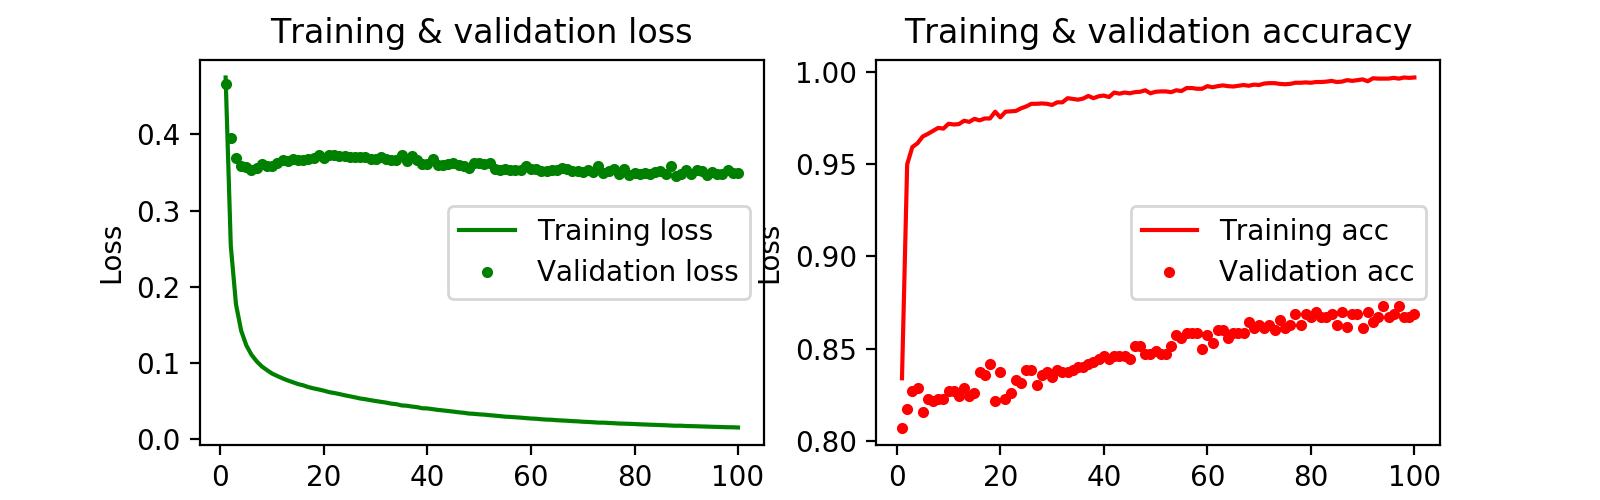

In [62]:
%matplotlib notebook
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['acc'] 
val_acc_values = history['val_acc']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [271]:
#### Period Classification (multi-class)

In [63]:
# create a dataframe (period) for CNN - train set 
period_df.columns = ['period']
doc_vec_df_with_period = pd.concat([doc_vec_df,period_df], axis = 1)
doc_vec_df_with_period['period'] = doc_vec_df_with_period['period'].map(period_num)
X_train_period = doc_vec_df_with_period.drop(['period'], axis = 1)
y_train_period = doc_vec_df_with_period.period

In [64]:
# create a dataframe (period) for CNN - validation set
period_df_val_set = pd.DataFrame(validation_set_df['period'])
period_df_val_set.columns = ['period']
doc_vec_df_val_set_w_period = pd.concat([doc_vec_df_val_set,period_df_val_set], axis = 1)
doc_vec_df_val_set_w_period['period'] = doc_vec_df_val_set_w_period['period'].map(period_num)
X_val_period = doc_vec_df_val_set_w_period.drop(['period'], axis = 1)
y_val_period = doc_vec_df_val_set_w_period.period

In [65]:
# create a dataframe (period) for CNN - test set
period_df_test_set = pd.DataFrame(test_set_df['period'])
period_df_test_set.columns = ['period']
doc_vec_df_test_set_w_period = pd.concat([doc_vec_df_test_set,period_df_test_set], axis = 1)
doc_vec_df_test_set_w_period['period'] = doc_vec_df_test_set_w_period['period'].map(period_num)
X_test_period = doc_vec_df_test_set_w_period.drop(['period'], axis = 1)
y_test_period = doc_vec_df_test_set_w_period.period

In [66]:
y_train_period = keras.utils.to_categorical(y_train_period, len(period_num))
y_val_period = keras.utils.to_categorical(y_val_period, len(period_num))
y_test_period = keras.utils.to_categorical(y_test_period, len(period_num))

In [67]:
softmax_model_period = Sequential()
softmax_model_period.add(Dense(100, activation='relu', input_shape=(20,)))
softmax_model_period.add(Dense(50, activation='relu'))
softmax_model_period.add(Dense(2, activation='softmax'))
softmax_model_period.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [68]:
softmax_model_period.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=0, validation_data=(X_val, y_val))

#### Doc2Vec by Unique ID
- instead of using the target labels (gender, author, etc..), use unique id as label 
- this is going to give us the vector representation of each document

In [69]:
# Create TaggedDocument objects for train_corpus_unique_id
train_corpus_unique_id = []
for i in range(0, len(train_set_df)):
    doc = TaggedDocument(train_set_df['text'][i].split(), [i])   
    train_corpus_unique_id.append(doc)

In [70]:
model_unique_id = Doc2Vec(vector_size=vec_size,
                min_count=min_count,
                epochs=epochs,
                alpha = alpha,
                min_alpha = min_alpha)

model_unique_id.build_vocab(train_corpus_unique_id)

%time model_unique_id.train(train_corpus_unique_id, total_examples = model.corpus_count, epochs = model.epochs)

CPU times: user 17.7 s, sys: 1.19 s, total: 18.9 s
Wall time: 8.85 s


In [71]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus_unique_id)):
    inferred_vector = model_unique_id.infer_vector(train_corpus_unique_id[doc_id].words)
    sims = model_unique_id.docvecs.most_similar([inferred_vector], topn=len(model_unique_id.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    #see how many it got correct and how many it didn't 
counter = Counter(ranks)

In [72]:
# accuracy 
counter 

Counter({0: 2360, 1: 56, 4: 4, 3: 10, 2: 14, 10: 2, 13: 1, 7: 1, 8: 1, 11: 1})

In [74]:
doc_vectors_unique_id = [model_unique_id.infer_vector(train_corpus_unique_id[i].words) for i in range(0,len(train_corpus_unique_id))]
doc_vectors_unique_id_df = pd.DataFrame(doc_vectors_unique_id)

In [75]:
train_set_labels = train_set_df[['author', 'sex', 'period']]

In [87]:
# reduce dimensionality to visualize the document vectors 
pca_unique = PCA(n_components = 3)
pca_unique.fit(doc_vectors_unique_id)
doc_vectors_3d_unique_id = pca_unique.transform(doc_vectors_unique_id) # transform the vectors to 3d space
explained_variance_ratio_unique = np.cumsum(pca_unique.explained_variance_ratio_)[2]
print('Explained variance ratio is {:.2f}%, {:.2f}% is lost by reducing the dimensionality'.format((explained_variance_ratio_unique*100), (100-(explained_variance_ratio_unique*100)))) 

Explained variance ratio is 37.75%, 62.25% is lost by reducing the dimensionality


In [88]:
doc_vectors_unique_id_3d_df = pd.DataFrame(doc_vectors_3d_unique_id)
doc_vectors_unique_id_3d_df.columns = ['x', 'y', 'z']
doc_vec_unique_id_df = pd.concat([doc_vectors_unique_id_3d_df, train_set_labels], axis = 1)
doc_vec_unique_id_df['author'] = doc_vec_unique_id_df['author'].map(author_num)
doc_vec_unique_id_df['sex'] = doc_vec_unique_id_df['sex'].map(sex_num)
doc_vec_unique_id_df['period'] = doc_vec_unique_id_df['period'].map(period_num)

doc_vectors_unique_id_df = pd.concat([doc_vectors_unique_id_df, train_set_labels], axis = 1)

In [89]:
def color_map(category):
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    jump = 256//len(category)
    cmaplist_ = [cmaplist[jump*i] for i in range(0,len(category))]
    return cmaplist_

cmap_author = color_map(authors)
cmap_sex = color_map(genders)
cmap_periods = color_map(periods)

In [90]:
from IPython.html.widgets import interact
def update_plot(w):
    if w == 'author':
        traces_for_plot_unique = []
        for key, value in author_num.items():
            df = doc_vec_unique_id_df[doc_vec_unique_id_df['author'] == value]
            traces_for_plot_unique.append(df)

        traces_unique_author = []
        for trace in traces_for_plot_unique:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = authors[trace['author'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_author[(trace['author'].values[0])]),
            )
            )
            traces_unique_author.append(trace1)
        layout = go.Layout(showlegend=True)
        fig = go.Figure(data= traces_unique_author, layout = layout)
        iplot(fig, filename='test1')
    if w == 'gender':
        traces_for_plot_unique_sex = []
        for key, value in sex_num.items():
            df = doc_vec_unique_id_df[doc_vec_unique_id_df['sex'] == value]
            traces_for_plot_unique_sex.append(df)

        traces_unique_gender = []
        for trace in traces_for_plot_unique_sex:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = genders[trace['sex'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_sex[(trace['sex'].values[0])]),
            )
            )
            traces_unique_gender.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_unique_gender, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')
    if w == 'time period':
        traces_for_plot_unique_period = []
        for key, value in period_num.items():
            df = doc_vec_unique_id_df[doc_vec_unique_id_df['period'] == value]
            traces_for_plot_unique_period.append(df)

        traces_unique_period = []
        for trace in traces_for_plot_unique_period:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = periods[trace['period'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_periods[(trace['period'].values[0])]),
            )
            )
            traces_unique_period.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_unique_period, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')

w = widgets.Dropdown(
    options= ['author','gender','time period'],
    value='author',
    description='Category:',
    disabled=False)
# w.observe(update_plot)
interact(update_plot, w=w)

interactive(children=(Dropdown(description='Category:', options=('author', 'gender', 'time period'), value='au…

<function __main__.update_plot(w)>

In [92]:
# doc_vectors_unique_id_df.to_csv('document_vectors_df.csv')

#### MLP for Unique-ID Vectors

In [93]:
# create a dataframe (gender) for CNN - train set 
doc_vectors_unique_id_df['sex'] = doc_vectors_unique_id_df['sex'].map(sex_num)
X_train_unique_id = doc_vectors_unique_id_df.drop(['author', 'sex', 'period'], axis = 1)
y_train_unique_id = doc_vectors_unique_id_df.sex

In [94]:
# vector representation of all documents in list form (for validation set)
doc_vectors_val_unique = [model_unique_id.infer_vector(val_corpus[i]) for i in range(0,len(val_corpus))]
# vector representation of all documents in list form (for test set)
doc_vectors_test_unique = [model_unique_id.infer_vector(test_corpus[i]) for i in range(0,len(test_corpus))]

In [95]:
# create a dataframe (gender) for CNN - validation set
doc_vec_df_unique_id_val_set = pd.DataFrame(doc_vectors_val_unique)
gender_df_val_set_unique = pd.DataFrame(validation_set_df['sex'])
gender_df_val_set_unique.columns = ['sex']
doc_vec_df_val_set_w_gender_unique = pd.concat([doc_vec_df_unique_id_val_set,gender_df_val_set_unique], axis = 1)
doc_vec_df_val_set_w_gender_unique['sex'] = doc_vec_df_val_set_w_gender_unique['sex'].map(sex_num)
X_val_unique = doc_vec_df_val_set_w_gender_unique.drop(['sex'], axis = 1)
y_val_unique = doc_vec_df_val_set_w_gender_unique.sex

# create a dataframe (gender) for CNN - test set
doc_vec_df_test_set_unique = pd.DataFrame(doc_vectors_test_unique)
gender_df_test_set_unique = pd.DataFrame(test_set_df['sex'])
gender_df_test_set_unique.columns = ['sex']
doc_vec_df_test_set_w_gender_unique = pd.concat([doc_vec_df_test_set_unique,gender_df_test_set_unique], axis = 1)
doc_vec_df_test_set_w_gender_unique['sex'] = doc_vec_df_test_set_w_gender_unique['sex'].map(sex_num)
X_test_unique = doc_vec_df_test_set_w_gender_unique.drop(['sex'], axis = 1)
y_test_unique = doc_vec_df_test_set_w_gender_unique.sex

In [96]:
y_train_unique_id = keras.utils.to_categorical(y_train_unique_id, 2)
y_val_unique = keras.utils.to_categorical(y_val_unique, 2)
y_test_unique = keras.utils.to_categorical(y_test_unique, 2)

In [97]:
sigmoid_model_unique = Sequential()
sigmoid_model_unique.add(Dense(100, activation='relu', input_shape=(20,)))
sigmoid_model_unique.add(Dense(50, activation='relu'))
sigmoid_model_unique.add(Dense(2, activation='sigmoid'))
sigmoid_model_unique.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [98]:
model_unique = sigmoid_model_unique.fit(X_train_unique_id, y_train_unique_id, epochs= 100, batch_size=32, verbose=0, validation_data=(X_val_unique, y_val_unique))

In [99]:
history_unique_id = model_unique.history

<IPython.core.display.Javascript object>


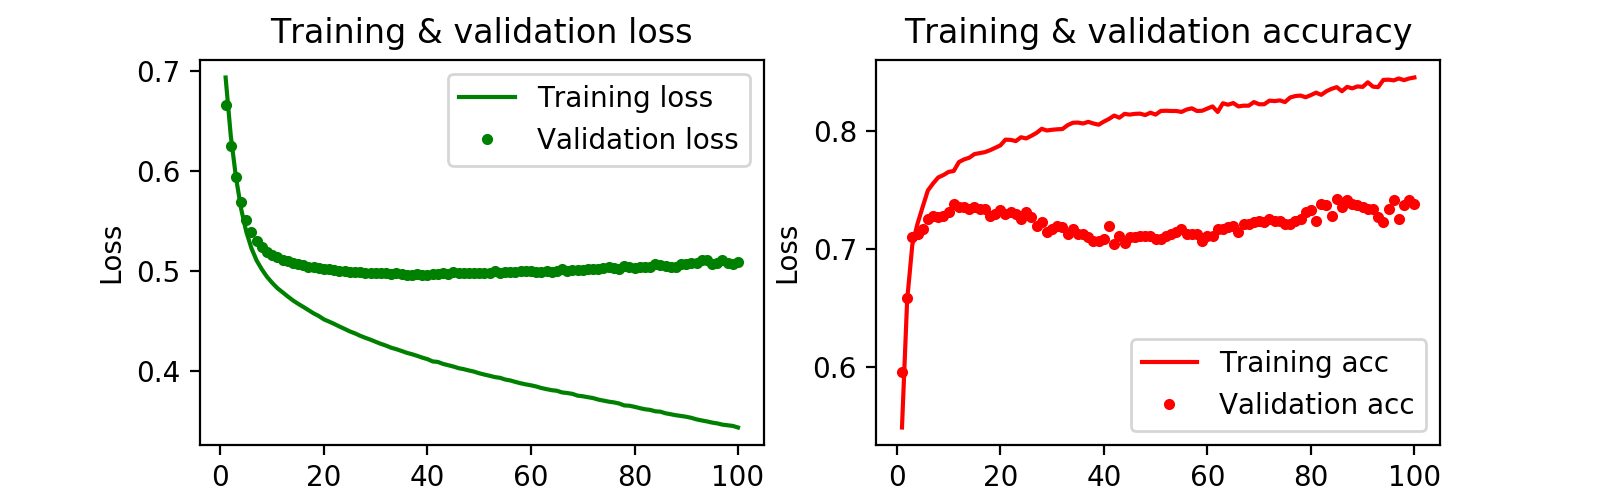

In [100]:
%matplotlib notebook
loss_values_unique_id = history_unique_id['loss']
val_loss_values_unique_id = history_unique_id['val_loss']
acc_values_unique_id = history_unique_id['acc'] 
val_acc_values_unique_id = history_unique_id['val_acc']
epochs_unique_id = range(1, len(loss_values_unique_id) + 1)

plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.plot(epochs_unique_id, loss_values_unique_id, 'g', label='Training loss')
plt.plot(epochs_unique_id, val_loss_values_unique_id, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs_unique_id, acc_values_unique_id, 'r', label='Training acc')
plt.plot(epochs_unique_id, val_acc_values_unique_id, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Early Stopping

In [101]:
model_unique_20 = sigmoid_model_unique.fit(X_train_unique_id, y_train_unique_id, epochs= 20, batch_size=32, verbose=0, validation_data=(X_val_unique, y_val_unique))

In [102]:
history_early_stop = model_unique_20.history

In [103]:
results_train_unique = sigmoid_model_unique.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique = sigmoid_model_unique.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {:.2f}%'.format(results_train_unique[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_test_unique[1]*100)) 

700/700 [==============================] - 0s 20us/step
Accuracy score for the training set is 85.71%
Accuracy score for the test set is 75.57%


<IPython.core.display.Javascript object>


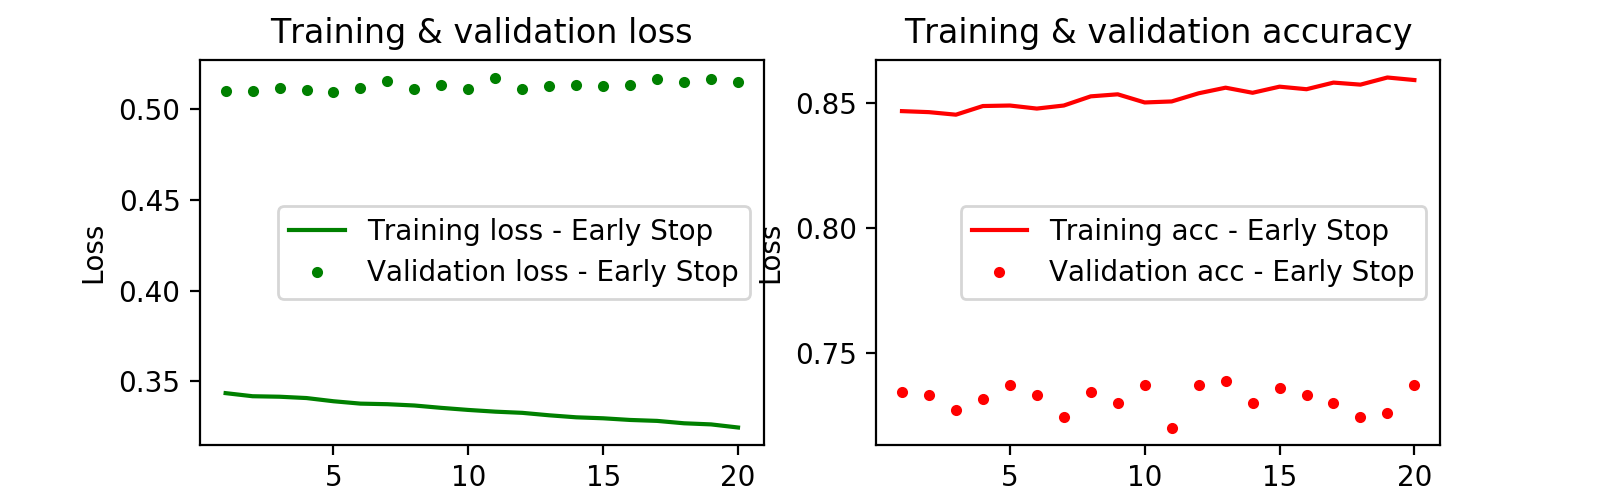

In [104]:
%matplotlib notebook
loss_values_unique_id_20 = history_early_stop['loss']
val_loss_values_unique_id_20 = history_early_stop['val_loss']
acc_values_unique_id_20 = history_early_stop['acc'] 
val_acc_values_unique_id_20 = history_early_stop['val_acc']
epochs_unique_id_20 = range(1, len(loss_values_unique_id_20) + 1)

plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.plot(epochs_unique_id_20, loss_values_unique_id_20, 'g', label='Training loss - Early Stop')
plt.plot(epochs_unique_id_20, val_loss_values_unique_id_20, 'g.', label='Validation loss - Early Stop')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs_unique_id_20, acc_values_unique_id_20, 'r', label='Training acc - Early Stop')
plt.plot(epochs_unique_id_20, val_acc_values_unique_id_20, 'r.', label='Validation acc - Early Stop')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### L1 Regularization (LASSO)

In [105]:
model_l1 = Sequential()
model_l1.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(20,))) #2 hidden layers
model_l1.add(Dense(50, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model_l1.add(Dense(2, activation='sigmoid'))

model_l1.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

L1_model = model_l1.fit(X_train_unique_id, y_train_unique_id,
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    validation_data=(X_val_unique, y_val_unique))

In [106]:
history_l1 = L1_model.history

In [107]:
results_train_unique_l1 = model_l1.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_l1 = model_l1.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {:.2f}%'.format(results_train_unique_l1[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_test_unique_l1[1]*100)) 

700/700 [==============================] - 0s 24us/step
Accuracy score for the training set is 77.59%
Accuracy score for the test set is 75.79%


#### L2 Regularization (Ridge)

In [108]:
model_l2 = Sequential()
model_l2.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(20,))) #2 hidden layers
model_l2.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_l2.add(Dense(2, activation='sigmoid'))

model_l2.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

L2_model = model_l2.fit(X_train_unique_id, y_train_unique_id,
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    validation_data=(X_val_unique, y_val_unique))

In [109]:
history_l2 = L2_model.history

In [110]:
results_train_unique_l2 = model_l2.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_l2 = model_l2.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {:.2f}%'.format(results_train_unique_l2[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_test_unique_l2[1]*100)) 

700/700 [==============================] - 0s 24us/step
Accuracy score for the training set is 83.61%
Accuracy score for the test set is 77.14%


#### Dropout

In [111]:
model_dropout = Sequential()
model_dropout.add(Dense(100, activation='relu', input_shape=(20,))) #2 hidden layers
model_dropout.add(Dropout(0.3))
model_dropout.add(Dense(50, activation='relu'))
model_dropout.add(Dropout(0.3))
model_dropout.add(Dense(2, activation='sigmoid'))

model_dropout.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

dropout_model = model_dropout.fit(X_train_unique_id, y_train_unique_id,
                    epochs=100,
                    batch_size=32,
                    verbose = 0,
                    validation_data=(X_val_unique, y_val_unique))

In [112]:
history_dropout = dropout_model.history

In [113]:
results_train_unique_dropout = model_dropout.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_dropout = model_dropout.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {:.2f}%'.format(results_train_unique_dropout[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_test_unique_dropout[1]*100)) 

700/700 [==============================] - 0s 22us/step
Accuracy score for the training set is 81.82%
Accuracy score for the test set is 76.57%


<IPython.core.display.Javascript object>


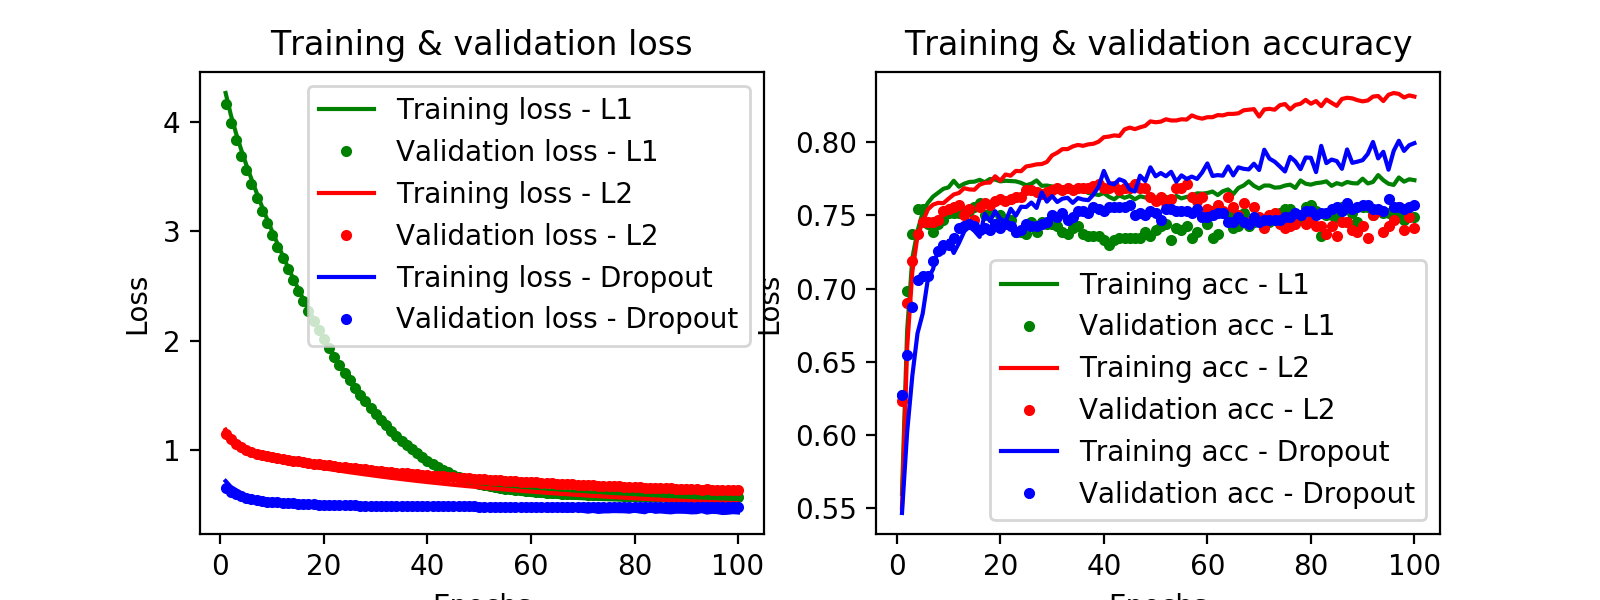

In [284]:
%matplotlib notebook

# L1
loss_values_l1 = history_l1['loss']
val_loss_values_l1 = history_l1['val_loss']
acc_values_l1 = history_l1['acc'] 
val_acc_values_l1 = history_l1['val_acc']
epochs_l1 = range(1, len(loss_values_l1) + 1)

# L2
loss_values_l2 = history_l2['loss']
val_loss_values_l2 = history_l2['val_loss']
acc_values_l2 = history_l2['acc'] 
val_acc_values_l2 = history_l2['val_acc']
epochs_l2 = range(1, len(loss_values_l2) + 1)

# Dropout
loss_values_dropout = history_dropout['loss']
val_loss_values_dropout = history_dropout['val_loss']
acc_values_dropout = history_dropout['acc'] 
val_acc_values_dropout = history_dropout['val_acc']
epochs_dropout = range(1, len(loss_values_dropout) + 1)

plt.figure(figsize = (8,3))

plt.subplot(121)
plt.plot(epochs_l1, loss_values_l1, 'g', label='Training loss - L1')
plt.plot(epochs_l1, val_loss_values_l1, 'g.', label='Validation loss - L1')
plt.plot(epochs_l2, loss_values_l2, 'r', label='Training loss - L2')
plt.plot(epochs_l2, val_loss_values_l2, 'r.', label='Validation loss - L2')
plt.plot(epochs_dropout, loss_values_dropout, 'b', label='Training loss - Dropout')
plt.plot(epochs_dropout, val_loss_values_dropout, 'b.', label='Validation loss - Dropout')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs_l1, acc_values_l1, 'g', label='Training acc - L1')
plt.plot(epochs_l1, val_acc_values_l1, 'g.', label='Validation acc - L1')
plt.plot(epochs_l2, acc_values_l2, 'r', label='Training acc - L2')
plt.plot(epochs_l2, val_acc_values_l2, 'r.', label='Validation acc - L2')
plt.plot(epochs_dropout, acc_values_dropout, 'b', label='Training acc - Dropout')
plt.plot(epochs_dropout, val_acc_values_dropout, 'b.', label='Validation acc - Dropout')

plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Initialization
#### He Initialization

In [121]:
model_he = Sequential()
model_he.add(Dense(100, input_shape=(20,), kernel_initializer= "he_normal",
                kernel_regularizer=regularizers.l2(0.005),
                activation='relu'))
model_he.add(Dropout(0.3))
model_he.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_he.add(Dropout(0.3))
model_he.add(Dense(2, activation='sigmoid'))

model_he.compile(optimizer= "sgd" ,loss='binary_crossentropy',metrics=['accuracy'])
he_ini = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [122]:
results_train_unique_he = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_he = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {:.2f}%'.format(results_train_unique_he[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_test_unique_he[1]*100)) 

700/700 [==============================] - 0s 32us/step
Accuracy score for the training set is 77.86%
Accuracy score for the test set is 75.50%


#### lecun_normal

In [123]:
model_lecun = Sequential()
model_lecun.add(Dense(100, input_shape=(20,), kernel_initializer= "lecun_normal",
                kernel_regularizer=regularizers.l2(0.005),
                activation='relu'))
model_lecun.add(Dropout(0.3))
model_lecun.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_lecun.add(Dropout(0.3))
model_lecun.add(Dense(2, activation='sigmoid'))

model_lecun.compile(optimizer= "sgd" ,loss='binary_crossentropy',metrics=['accuracy'])
lecun_ini = model_lecun.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [124]:
results_train_unique_lecun = model_lecun.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_lecun = model_lecun.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {:.2f}%'.format(results_train_unique_lecun[1]*100))
print('Accuracy score for the test set is {:.2f}%'.format(results_test_unique_lecun[1]*100)) 

700/700 [==============================] - 0s 28us/step
Accuracy score for the training set is 77.24%
Accuracy score for the test set is 75.64%


### Optimization
#### RMSProp

In [125]:
model_he.compile(optimizer= "rmsprop" ,loss='binary_crossentropy',metrics=['accuracy'])
model_rmsprop = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [126]:
results_train_rmsprop = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_rmsprop = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_rmsprop[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_rmsprop[1]*100),2)) 

700/700 [==============================] - 0s 26us/step
Accuracy score for the training set is 83.0%
Accuracy score for the test set is 76.0%


#### Adam

In [127]:
model_he.compile(optimizer= "Adam" ,loss='binary_crossentropy',metrics=['accuracy'])
model_adam = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [128]:
results_train_adam = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_adam = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_adam[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_adam[1]*100),2)) 

700/700 [==============================] - 0s 28us/step
Accuracy score for the training set is 85.0%
Accuracy score for the test set is 77.0%


#### Learning Rate Decay

In [129]:
sgd_learning_rate = optimizers.SGD(lr=0.03, decay=0.0001, momentum=0.9)
model_he.compile(optimizer= sgd_learning_rate ,loss='binary_crossentropy',metrics=['accuracy'])
learning_rate_decay = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique), verbose = 0)

In [130]:
results_train_lrd = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_lrd = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_lrd[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_lrd[1]*100),2)) 

700/700 [==============================] - 0s 31us/step
Accuracy score for the training set is 82.0%
Accuracy score for the test set is 78.0%
